In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv('BTCUSDT_Binance_futures_data_day.csv',skiprows=1)

In [3]:
data.date = pd.to_datetime(data.date)

In [4]:
data.set_index('date',inplace= True)

In [5]:
data = data.asfreq('d')

In [6]:
data.drop(columns=['unix','symbol'], inplace=True)

In [8]:
target = data['close']
features = data.drop('close', axis=1)

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler()

# This will scale the features using the z-score
zscore = ss.fit_transform(features)

#recreate the df
features_ss = pd.DataFrame(zscore, index = features.index, columns = features.columns)
features_ss = features_ss.reset_index(drop=True)
print(features_ss.head())

       open      high       low  Volume BTC  Volume USDT  tradecount
0 -0.989279 -0.982281 -0.972307   -1.499579    -1.187726   -1.195558
1 -0.971646 -0.978877 -0.967857   -1.447839    -1.173653   -1.192038
2 -0.972182 -0.983887 -0.975714   -1.473229    -1.180637   -1.192602
3 -0.984029 -0.988751 -0.978972   -1.465161    -1.178641   -1.190864
4 -0.980198 -0.980252 -0.969880   -1.444374    -1.172829   -1.187948


In [10]:
mm = MinMaxScaler()
minmax = mm.fit_transform(features)

#create a df again
features_mm = pd.DataFrame(minmax, index=features.index, columns=features.columns)
features_mm = features_mm.reset_index(drop=True)
print(features_mm.head())

       open      high       low  Volume BTC  Volume USDT  tradecount
0  0.083344  0.079129  0.101761    0.000000     0.000000    0.000000
1  0.088382  0.080114  0.102993    0.007242     0.002274    0.000511
2  0.088229  0.078664  0.100818    0.003688     0.001145    0.000430
3  0.084844  0.077256  0.099915    0.004818     0.001468    0.000682
4  0.085939  0.079716  0.102433    0.007727     0.002407    0.001106


In [11]:
features_group = {'standard_scaler': features_ss, 'min_max_scaler': features_mm, 'no_scaling': features}

In [12]:
results_data = pd.DataFrame()

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [15]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, target,
                                                        test_size=0.25,
                                                        random_state=42)
    # build the model
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # get the predictions for the test dataset
    predictions = model.predict(X_test)

    # R-squared training
    r2_train = model.score(X_train, Y_train)

    # R-squared testing
    r2_test = model.score(X_test, Y_test)

    #Compare predictions with Y_test
    mse = mean_squared_error(Y_test, predictions)

    #Root Mean Squared Error
    rmse=mse**0.5
                    
    results_data = results_data.append({'Model': 'Linear Regression', 'Scaling': key,
                    'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)
    
results_data 

,Model,Scaling,RMSE,R2_Test,R2_Train
0,Linear Regression,standard_scaler,570.06807,0.999011,0.998833
1,Linear Regression,min_max_scaler,570.06807,0.999011,0.998833
2,Linear Regression,no_scaling,570.06807,0.999011,0.998833


In [16]:
feat = list(X_train.columns)
coef=model.coef_.transpose()
coef_table = np.stack((feat,coef)).T
data_coef = pd.DataFrame(coef_table, columns=['Feature','Coefficients'])
data_coef

,Feature,Coefficients
0,open,-0.3219428532232052
1,high,0.7456906339929786
2,low,0.576470312258856
3,Volume BTC,-0.00031282885583358013
4,Volume USDT,-3.621399384386515e-08
5,tradecount,0.00013958251825225352


In [17]:
from sklearn.linear_model import Ridge, Lasso 
from sklearn.model_selection import GridSearchCV

In [20]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, target,
                                                        test_size=0.25,
                                                        random_state=42)

    # setting the parameter grid for hyperparameter tuning
    grid_parameters = {'alpha': np.linspace(10,0,100)}

    grid = GridSearchCV(Lasso(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, Y_train)
    best_lasso_alpha=grid.best_estimator_.alpha
    
    lasso = Lasso(alpha=best_lasso_alpha)
    
    #fit model
    lasso.fit(X_train, Y_train)
    
    lasso_pred = lasso.predict(X_test)
    
    # R-squared training
    r2_train = lasso.score(X_train, Y_train)

    # R-squared testing
    r2_test = lasso.score(X_test, Y_test)

    mse = np.mean((lasso_pred - Y_test)**2) 
    rmse = mse**0.5

    results_data = results_data.append({'Model': 'Lasso Regression', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'Alpha = ' + str(best_lasso_alpha)}, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21368883.943921268, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21469822.596675694, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21575146.9569889, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22608703.685369372, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25245638.549693525, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22620553.19546905, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43985420.597812235, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23339653.8004843, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45580359.3876535, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26820101.813807577, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23036890.09342128, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21571620.001821518, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25648909.228583902, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26917627.135005683, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69000814.74783234, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33785103.20632082, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34678946.67293522, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76654137.00587466, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43536507.22557545, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43744801.356496334, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83609708.06628786, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54906845.75754762, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55361074.43372634, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89705657.43650113, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95736521.36289501, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72793738.53947538, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72801785.2680904, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83553636.19827113, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81053323.42311461, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99833751.8581698, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104627455.10208087, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105327557.15049359, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102085151.249672, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120779237.04809047, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123538264.06787914, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120364358.19115934, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20972035.055747002, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20898349.67910409, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20630483.349568546, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46139798.41964626, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44770387.68282613, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44886185.069909155, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94414379.82106954, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93578869.25009733, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91151655.57480727, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132025368.15292138, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136629269.63613757, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133941470.4269848, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132024760.13118999, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136628656.22002953, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133940851.02661836, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133940231.62505217, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105212863.61059467, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122486641.59742501, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132023544.08387822, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136627429.3840713, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133939612.22228046, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122485545.3217451, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132022936.05829899, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136626815.964222, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105210807.33451355, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122484947.35142641, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132022328.031437, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122484150.05573335, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132021517.32695818, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136625384.64639467, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105209113.92238325, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122483552.08251032, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132020909.29710148, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122482854.44551386, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132020199.92731485, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136624055.55947578, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105207541.46155567, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122482256.46959376, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132019591.89468043, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136622828.70481554, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133934966.66321851, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105206694.74920031, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132018375.82555915, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136622215.27561766, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133934347.2502392, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105205364.19743122, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122480462.534364, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132017767.78907487, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133933211.65665524, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105204638.4399694, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122479864.55346505, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136620477.2194474, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133932592.24026863, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105203912.68113512, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132016045.01206945, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136619863.78546974, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133931972.8226843, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132015436.97066808, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

In [21]:
results_data

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Linear Regression,standard_scaler,570.068070,0.999011,0.998833,NaN
1,Linear Regression,min_max_scaler,570.068070,0.999011,0.998833,NaN
2,Linear Regression,no_scaling,570.068070,0.999011,0.998833,NaN
3,Lasso Regression,standard_scaler,567.160337,0.999021,0.998799,Alpha = 0.20202020202020243
4,Lasso Regression,min_max_scaler,565.240185,0.999028,0.998800,Alpha = 0.0
5,Lasso Regression,no_scaling,565.240185,0.999028,0.998800,Alpha = 0.0


Best degree: {'poly__degree': 1}


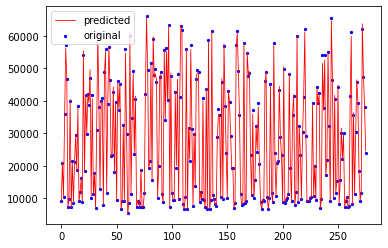

Best degree: {'poly__degree': 1}


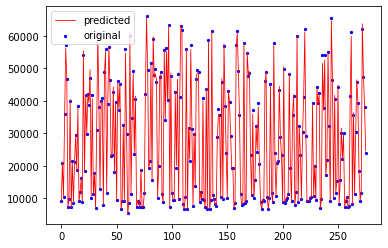

Best degree: {'poly__degree': 1}


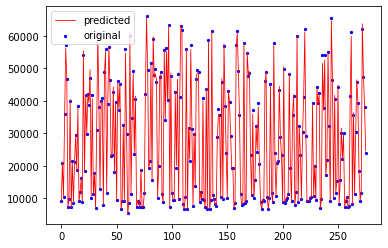

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
for key, curr_features in features_group.items():
    #Separate the data
    X_train_p, X_test_p, Y_train_p, Y_test_p = train_test_split(curr_features, target,
                                                        test_size=0.25,
                                                        random_state=42)

    #generate Polynomial with Linear regression using a range of degrees on CV
    rmse_list=[]
    r2_list =[]
    linear_model = LinearRegression()

    #poly degrees to search
    param_grid = {'poly__degree': np.arange(1,6,1)}

    steps = []
    # create and fit a ridge regression model, testing each alpha
    steps=[('poly', PolynomialFeatures()), ('linear', linear_model)]
    pipeline = Pipeline(steps)

    cv = GridSearchCV(pipeline, param_grid, cv=5, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True)
    #feature_transform=cv.fit_transform(features_p1)
    cv.fit(X_train_p, Y_train_p)
    best_poly_deg = cv.best_params_['poly__degree']
    print("Best degree:", cv.best_params_)   

    #define poly object with degree
    pre_poly = PolynomialFeatures(degree=best_poly_deg)
    #transform X to use in poly
    X_train_poly = pre_poly.fit_transform(X_train_p)
    X_test_poly = pre_poly.transform(X_test_p)
    #create regression object
    pol_reg = LinearRegression()
    #fit model
    pol_reg.fit(X_train_poly, Y_train_p)

    #store predicted price 
    y_predict = pol_reg.predict(X_test_poly)

    #find r-squared
    r2_train = pol_reg.score(X_train_poly, Y_train_p)
    r2_test=pol_reg.score(X_test_poly, Y_test_p)

    #find rmse
    mse = np.mean((y_predict - Y_test_p)**2) 
    rmse=mse**0.5

    # Plot the prediction vs actual values
    x_ax = range(len(y_predict))
    plt.scatter(x_ax, Y_test_p, s=5, color="blue", label="original")
    plt.plot(x_ax, y_predict, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    results_data = results_data.append({'Model': 'Polynomial Regression (Linear)', 'Scaling': key, 'Params': 'Degree = ' + str(best_poly_deg),
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)

In [23]:
results_data

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Linear Regression,standard_scaler,570.068070,0.999011,0.998833,NaN
1,Linear Regression,min_max_scaler,570.068070,0.999011,0.998833,NaN
2,Linear Regression,no_scaling,570.068070,0.999011,0.998833,NaN
3,Lasso Regression,standard_scaler,567.160337,0.999021,0.998799,Alpha = 0.20202020202020243
4,Lasso Regression,min_max_scaler,565.240185,0.999028,0.998800,Alpha = 0.0
5,Lasso Regression,no_scaling,565.240185,0.999028,0.998800,Alpha = 0.0
6,Polynomial Regression (Linear),standard_scaler,570.068070,0.999011,0.998833,Degree = 1
7,Polynomial Regression (Linear),min_max_scaler,570.068070,0.999011,0.998833,Degree = 1
8,Polynomial Regression (Linear),no_scaling,570.068070,0.999011,0.998833,Degree = 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132015437.97393885, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136619251.3624162, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133931354.42594105, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125808360.53511803, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122719445.98183876, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96698309.41901484, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110664906.72852728, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113458499.82488135, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111457984.21768521, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102147368.64130376, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103942144.66515055, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105563401.33043562, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105105542.85789746, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96198712.43644005, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94404721.92248757, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98502134.9253797, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100252098.02778892, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98871525.8366658, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93206382.65788713, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87805477.28616565, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132015515.22566941, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125808411.1023693, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122719495.64782684, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96698361.12336534, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110664958.68152773, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113458551.2504333, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111458036.87257116, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

Best degree: {'lasso__alpha': 0.001, 'poly__degree': 1}


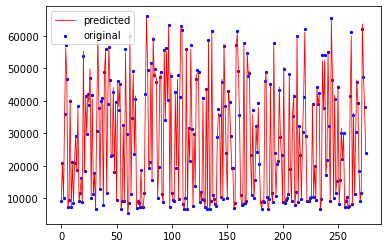

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132015437.97393885, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136619251.3624162, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133931354.42594105, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125808360.53511803, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122719445.98183876, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96698309.41901484, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110664906.72852728, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113458499.82488135, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111457984.21768521, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102147368.64130376, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103942144.66515055, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105563401.33043562, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105105542.85789746, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96198712.43644005, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94404721.92248757, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98502134.9253797, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100252098.02778892, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98871525.8366658, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93206382.65788713, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87805477.28616565, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132015515.22566941, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125808411.1023693, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122719495.64782684, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96698361.12336534, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110664958.68152773, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113458551.2504333, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111458036.87257116, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

Best degree: {'lasso__alpha': 0.001, 'poly__degree': 1}


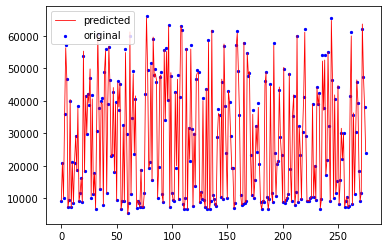

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132015437.97393885, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136619251.3624162, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133931354.42594105, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118711414.33553813, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125808360.53511803, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122719445.98183876, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110664906.72852728, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113458499.82488135, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111457984.21768521, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102147368.64130376, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103942144.66515055, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105563401.33043562, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105105542.85789746, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96198712.43644005, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94404721.92248757, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98502134.9253797, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100252098.02778892, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98871525.8366658, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93206382.65788713, tolerance: 21963602.187627237
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87805477.28616565, tolerance: 20496063.342384215
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132015515.22566941, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118711465.28687017, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125808411.1023693, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122719495.64782684, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110664958.68152773, tolerance: 20788579.561630707
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113458551.2504333, tolerance: 21136178.32238359
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111458036.87257116, tolerance: 21530255.338901315
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

Best degree: {'lasso__alpha': 0.001, 'poly__degree': 1}


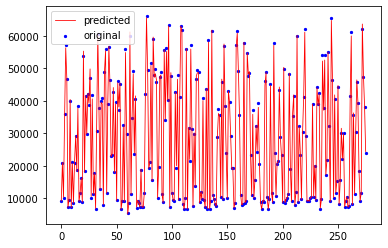

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
for key, curr_features in features_group.items():
    #Separate the data
    X_train_p, X_test_p, Y_train_p, Y_test_p = train_test_split(curr_features, target,
                                                        test_size=0.25,
                                                        random_state=42)
    rmse_list=[]
    r2_list =[]
    
    #poly degrees and lasso alphas to search
    param_grid = {'poly__degree': np.arange(1,6,1),
                  'lasso__alpha': np.linspace(0.001,0.1,10)}

    #create pipeline
    steps = []
    steps=[('poly', PolynomialFeatures()), ('lasso', Lasso())]
    pipeline = Pipeline(steps)

    #gridsearch with 5 folds
    cv = GridSearchCV(pipeline, param_grid, cv=5, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True)
    #feature_transform=cv.fit_transform(features_p1)
    cv.fit(X_train, Y_train)
    print("Best degree:", cv.best_params_) 

    #obtain hyperparameters
    best_poly_deg = cv.best_params_['poly__degree']
    best_lasso_alpha = cv.best_params_['lasso__alpha']

    #define poly object with degree
    pre_poly = PolynomialFeatures(degree=best_poly_deg)
    #transform X to use in poly
    X_train_poly = pre_poly.fit_transform(X_train_p)
    X_test_poly = pre_poly.transform(X_test_p)
    #create regression object
    pol_reg = Lasso(best_lasso_alpha)
    #fit model
    pol_reg.fit(X_train_poly, Y_train_p)

    #store predicted price 
    y_predict = pol_reg.predict(X_test_poly)

    #find r-squared
    r2_train = pol_reg.score(X_train_poly, Y_train_p)
    r2_test=pol_reg.score(X_test_poly, Y_test_p)

    #find rmse
    mse = np.mean((y_predict - Y_test_p)**2) 
    rmse=mse**0.5

    # Plot the prediction vs actual values
    x_ax = range(len(y_predict))
    plt.scatter(x_ax, Y_test_p, s=5, color="blue", label="original")
    plt.plot(x_ax, y_predict, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    results_data = results_data.append({'Model': 'Polynomial Regression (Lasso)', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'Alpha = ' + str(best_lasso_alpha) + '; Degree = ' + str(best_poly_deg) }, ignore_index=True)

In [25]:
results_data

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Linear Regression,standard_scaler,570.068070,0.999011,0.998833,NaN
1,Linear Regression,min_max_scaler,570.068070,0.999011,0.998833,NaN
2,Linear Regression,no_scaling,570.068070,0.999011,0.998833,NaN
3,Lasso Regression,standard_scaler,567.160337,0.999021,0.998799,Alpha = 0.20202020202020243
4,Lasso Regression,min_max_scaler,565.240185,0.999028,0.998800,Alpha = 0.0
5,Lasso Regression,no_scaling,565.240185,0.999028,0.998800,Alpha = 0.0
6,Polynomial Regression (Linear),standard_scaler,570.068070,0.999011,0.998833,Degree = 1
7,Polynomial Regression (Linear),min_max_scaler,570.068070,0.999011,0.998833,Degree = 1
8,Polynomial Regression (Linear),no_scaling,570.068070,0.999011,0.998833,Degree = 1
9,Polynomial Regression (Lasso),standard_scaler,565.249519,0.999028,0.998800,Alpha = 0.001; Degree = 1


In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, target,
                                                        test_size=0.25,
                                                        random_state=42)

    # setting the parameter grid for hyperparameter tuning
    grid_parameters = {'max_depth': np.arange(2,10,1)}

    grid = GridSearchCV(DecisionTreeRegressor(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, Y_train)
    best_para=grid.best_estimator_.max_depth
  
    dec_reg = DecisionTreeRegressor(max_depth=best_para)
    
    #fit model
    dec_reg.fit(X_train, Y_train)
    
    dec_pred = dec_reg.predict(X_test)
    
    # R-squared training
    r2_train = dec_reg.score(X_train, Y_train)

    # R-squared testing
    r2_test = dec_reg.score(X_test, Y_test)

    mse = np.mean((dec_pred - Y_test)**2) 
    rmse = mse**0.5

    results_data = results_data.append({'Model': 'Decision Tree Regressor', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'max_depth = ' + str(best_para)}, ignore_index=True)

In [28]:
results_data

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Linear Regression,standard_scaler,570.068070,0.999011,0.998833,NaN
1,Linear Regression,min_max_scaler,570.068070,0.999011,0.998833,NaN
2,Linear Regression,no_scaling,570.068070,0.999011,0.998833,NaN
3,Lasso Regression,standard_scaler,567.160337,0.999021,0.998799,Alpha = 0.20202020202020243
4,Lasso Regression,min_max_scaler,565.240185,0.999028,0.998800,Alpha = 0.0
5,Lasso Regression,no_scaling,565.240185,0.999028,0.998800,Alpha = 0.0
6,Polynomial Regression (Linear),standard_scaler,570.068070,0.999011,0.998833,Degree = 1
7,Polynomial Regression (Linear),min_max_scaler,570.068070,0.999011,0.998833,Degree = 1
8,Polynomial Regression (Linear),no_scaling,570.068070,0.999011,0.998833,Degree = 1
9,Polynomial Regression (Lasso),standard_scaler,565.249519,0.999028,0.998800,Alpha = 0.001; Degree = 1


In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, target,
                                                        test_size=0.25,
                                                        random_state=42)

    # setting the parameter grid for hyperparameter tuning
    grid_parameters = {'max_depth': np.arange(2,10,1)}

    grid = GridSearchCV(RandomForestRegressor(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, Y_train)
    best_para=grid.best_estimator_.max_depth
  
    rf_reg = RandomForestRegressor(max_depth=best_para, max_features=None)
    
    #fit model
    rf_reg.fit(X_train, Y_train)
    
    rf_pred = rf_reg.predict(X_test)
    
    # R-squared training
    r2_train = rf_reg.score(X_train, Y_train)

    # R-squared testing
    r2_test = rf_reg.score(X_test, Y_test)

    mse = np.mean((rf_pred - Y_test)**2) 
    rmse = mse**0.5

    results_data = results_data.append({'Model': 'RandomForest Regressor', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'max_depth = ' + str(best_para)}, ignore_index=True)

In [31]:
results_data = results_data.sort_values(by=['RMSE'])
results_data

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
5,Lasso Regression,no_scaling,565.240185,0.999028,0.998800,Alpha = 0.0
4,Lasso Regression,min_max_scaler,565.240185,0.999028,0.998800,Alpha = 0.0
11,Polynomial Regression (Lasso),no_scaling,565.240186,0.999028,0.998800,Alpha = 0.001; Degree = 1
9,Polynomial Regression (Lasso),standard_scaler,565.249519,0.999028,0.998800,Alpha = 0.001; Degree = 1
10,Polynomial Regression (Lasso),min_max_scaler,565.269410,0.999028,0.998800,Alpha = 0.001; Degree = 1
3,Lasso Regression,standard_scaler,567.160337,0.999021,0.998799,Alpha = 0.20202020202020243
2,Linear Regression,no_scaling,570.068070,0.999011,0.998833,NaN
0,Linear Regression,standard_scaler,570.068070,0.999011,0.998833,NaN
7,Polynomial Regression (Linear),min_max_scaler,570.068070,0.999011,0.998833,Degree = 1
1,Linear Regression,min_max_scaler,570.068070,0.999011,0.998833,NaN


In [36]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [39]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 398)               2786      
_________________________________________________________________
dense_10 (Dense)             (None, 199)               79401     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 200       
Total params: 82,387
Trainable params: 82,387
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


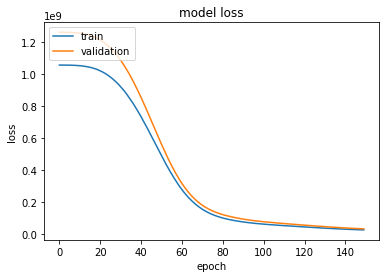

5388.498684598919
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 398)               2786      
_________________________________________________________________
dense_13 (Dense)             (None, 199)               79401     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 200       
Total params: 82,387
Trainable params: 82,387
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


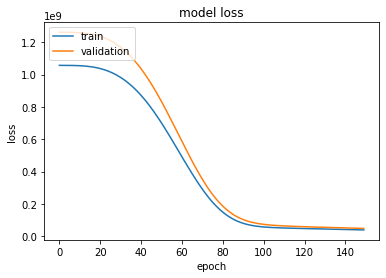

6266.940220058981


In [51]:
# Simple NN
#Loop through our different sets of features
for key, curr_features in features_group.items():

    #Skip non-scaled features
    if key == 'no_scaling':
        continue

    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, target,
                                                            test_size=0.25,
                                                            random_state=42)

    # Hidden layer neurons = Training Data Samples/ (Factor * (Input Neurons + Output Neurons))
    # Considering the 4788 input rows, and a factor of 4 for the first hidden layer: 398 neurons (177 354)

    model = Sequential()
    model.add(Dense(398, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(199, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history=model.fit(X_train, Y_train, epochs=150, batch_size=150, verbose=0, validation_split=0.2
                      , callbacks=[EarlyStopping( monitor='val_loss', patience=10)])
    predictions_train = model.predict(X_train)
    predictions = model.predict(X_test)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    rmse = mean_squared_error(Y_test, predictions) ** 0.5
    
    # R-squared training
    r2_train = r2_score(Y_train, predictions_train)

    # R-squared testing
    r2_test = r2_score(Y_test, predictions)
    
    results_data = results_data.append({'Model': 'Neural Network', 'Scaling': key, 'Params': 'See NN topology',
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)
    print(rmse)


In [52]:
results_data = results_data.sort_values(by=['RMSE'])
results_data

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Lasso Regression,no_scaling,565.240185,0.999028,0.998800,Alpha = 0.0
1,Lasso Regression,min_max_scaler,565.240185,0.999028,0.998800,Alpha = 0.0
2,Polynomial Regression (Lasso),no_scaling,565.240186,0.999028,0.998800,Alpha = 0.001; Degree = 1
3,Polynomial Regression (Lasso),standard_scaler,565.249519,0.999028,0.998800,Alpha = 0.001; Degree = 1
4,Polynomial Regression (Lasso),min_max_scaler,565.269410,0.999028,0.998800,Alpha = 0.001; Degree = 1
5,Lasso Regression,standard_scaler,567.160337,0.999021,0.998799,Alpha = 0.20202020202020243
6,Linear Regression,no_scaling,570.068070,0.999011,0.998833,NaN
7,Linear Regression,standard_scaler,570.068070,0.999011,0.998833,NaN
8,Polynomial Regression (Linear),min_max_scaler,570.068070,0.999011,0.998833,Degree = 1
9,Linear Regression,min_max_scaler,570.068070,0.999011,0.998833,NaN


In [53]:
print(features.columns)

Index(['open', 'high', 'low', 'Volume BTC', 'Volume USDT', 'tradecount'], dtype='object')


In [54]:
# Creating a dataframe for new predictions
data_new = [
    # Positive tweets scenario
    [60000000000, '08-02-2021', 0.9, 0, 0.1, 100],
    # Neutral tweets scenario    
    [60000000000, '08-02-2021', 0, 0, 1, 100],
    # Negative tweets scenario
    [60000000000, '08-02-2021', 0, 0.9, 0.1, 100],
    # Large number of tweets
    [60000000000, '08-02-2021', 0, 0, 1, 500],
    # Small number of tweets
    [60000000000, '08-02-2021', 0, 0, 1, 10]
           ]

df_new = pd.DataFrame(data_new, columns = ['total_vol', 'date', 'positive', 'negative', 'neutral', 'total_tweets'])

#Converting dates to ordinal
df_new['date']=pd.to_datetime(df_new['date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
df_new['date']=pd.to_datetime(df_new['date']).map(dt.datetime.toordinal)


In [55]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_group['no_scaling'])
scaled_new = scaler.transform(df_new)

In [56]:
rf_reg = RandomForestRegressor(max_depth=9, max_features=None,
                                                    random_state=42)

#fit model
rf_reg.fit(scaled_features, target)

predictions = rf_reg.predict(scaled_new)

print("Example - applying model for new predictions:")
print("Pos tweets\tNeu tweets\tNeg tweets\tMany tweets\tFew tweets")
print(predictions)

Example - applying model for new predictions:
Pos tweets	Neu tweets	Neg tweets	Many tweets	Few tweets
[36825.90169048 36825.90169048 36825.90169048 36825.90169048
 36825.90169048]
